In [1]:
import glob
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from confidence_interval import (
    calculate_confidence_interval,
    compare_model_accuracies,
    compare_logo_cv_models,
)
from charts import model_swarmplot, plot_model_comparison_table, plot_confusion_matrix


model_names = [
    "Simple1d",
    "Simple1dEmbedding",
    "Simple2d",
    "Simple2dEmbedding",
    "ResNet50",
    "ResNet50Embedding",
]
target_features = ["endianness", "instructionwidth_type"]
train_test_suites = ["BuildCross-All.csv", "Combined-All.csv", "CpuRec-All.csv"]
cross_validation_suites = [
    "LOGO-*.csv",
    #    "KFold-all.csv", Ignore since it does not give us much
]
directory = "./input/"


index_0 = ["little", "fixed"]
index_1 = ["big", "variable"]

### Crossvalidation Comparisons



Simple1d - LOGO-*.csv:
Raw confusion matrix (averaged across 10 runs):
                  big     little
       big    44545.8    11671.2
    little    17872.3    22305.7

Simple1d-E - LOGO-*.csv:
Raw confusion matrix (averaged across 10 runs):
                  big     little
       big    53059.3     3157.7
    little     6200.5    33977.5

Simple2d - LOGO-*.csv:
Raw confusion matrix (averaged across 10 runs):
                  big     little
       big    39515.2    16701.8
    little    22051.8    18126.2

Simple2d-E - LOGO-*.csv:
Raw confusion matrix (averaged across 10 runs):
                  big     little
       big    49452.8     6764.2
    little     7195.6    32982.4

ResNet50 - LOGO-*.csv:
Raw confusion matrix (averaged across 10 runs):
                  big     little
       big    39846.9    16370.1
    little    20817.6    19360.4

ResNet50-E - LOGO-*.csv:
Raw confusion matrix (averaged across 10 runs):
                  big     little
       big    47292.6     8924.4
 

/var/folders/5k/wrmk17fd2nz29w2bspmq6bm00000gn/T/ipykernel_80636/2184297983.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))



Simple2d-E - LOGO-*.csv:
Raw confusion matrix (averaged across 10 runs):
                  big     little
       big    54577.5    10080.5
    little     5038.7    26698.3

ResNet50 - LOGO-*.csv:
Raw confusion matrix (averaged across 10 runs):
                  big     little
       big    58275.0     6383.0
    little    13989.1    17747.9

ResNet50-E - LOGO-*.csv:
Raw confusion matrix (averaged across 10 runs):
                  big     little
       big    59483.8     5174.2
    little     9920.5    21816.5

ResNet50-E - LOGO-*.csv:
Raw confusion matrix (averaged across 10 runs):
                  big     little
       big    55561.3     9096.7
    little     9545.9    22191.1


<Figure size 800x600 with 0 Axes>

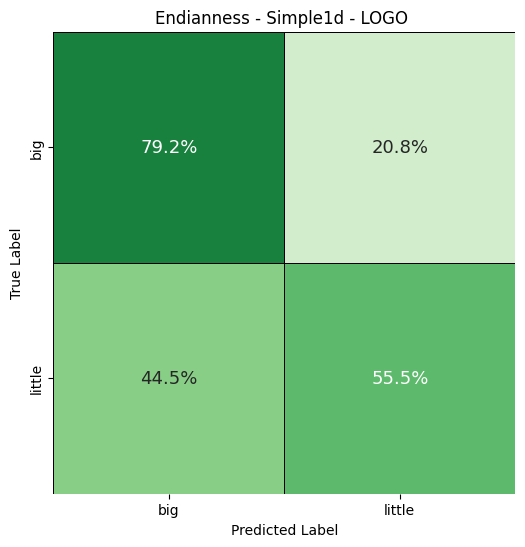

<Figure size 800x600 with 0 Axes>

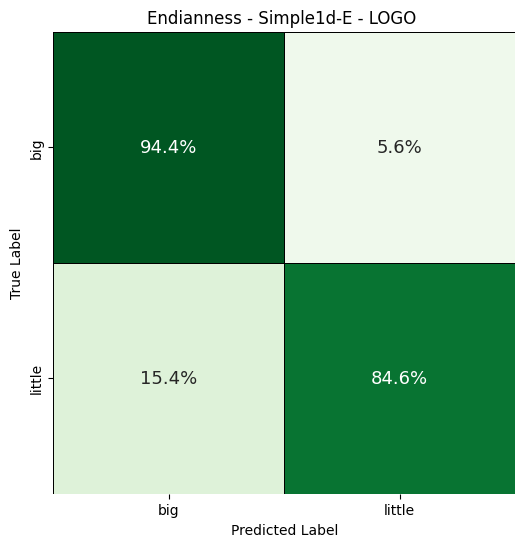

<Figure size 800x600 with 0 Axes>

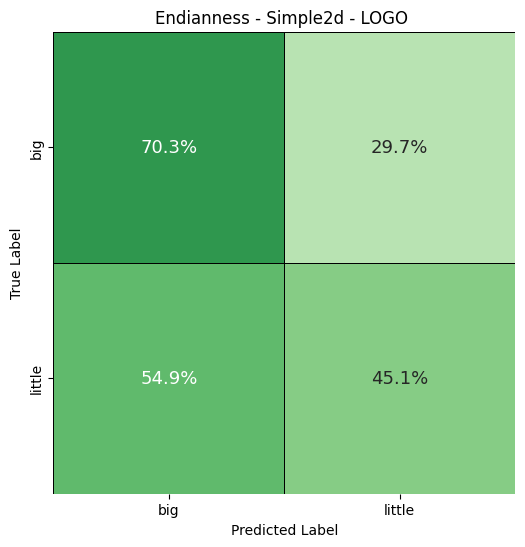

<Figure size 800x600 with 0 Axes>

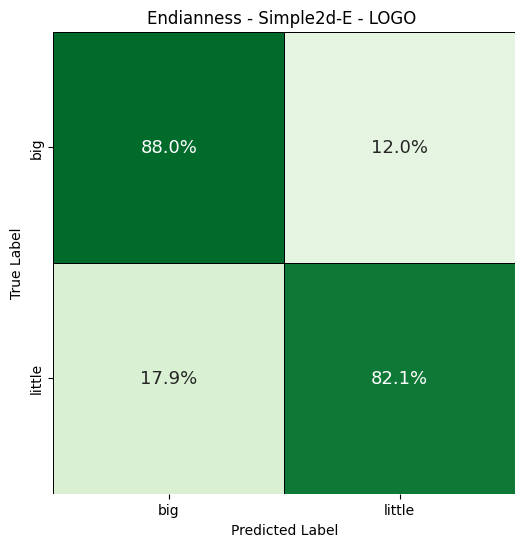

<Figure size 800x600 with 0 Axes>

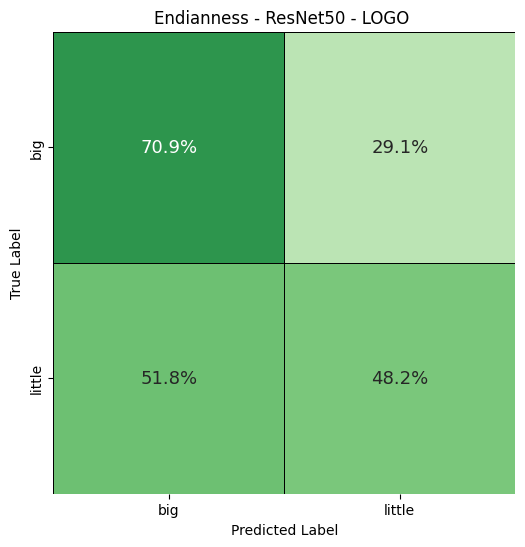

<Figure size 800x600 with 0 Axes>

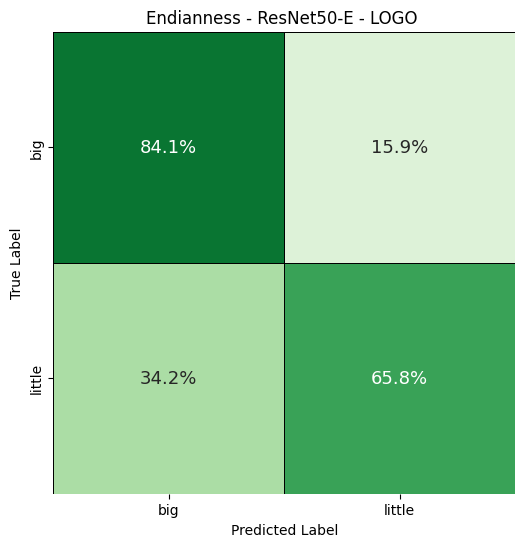

<Figure size 800x600 with 0 Axes>

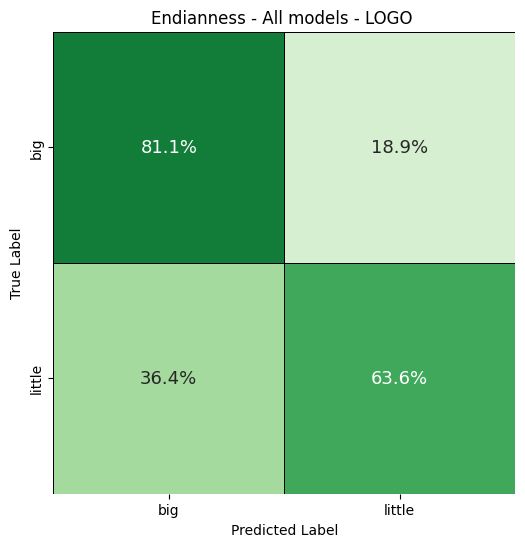

<Figure size 800x600 with 0 Axes>

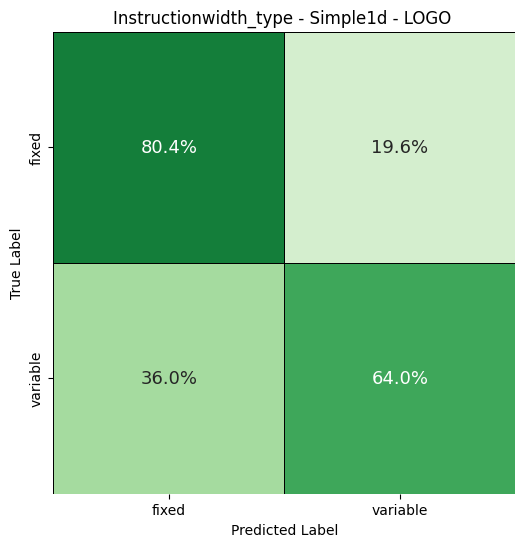

<Figure size 800x600 with 0 Axes>

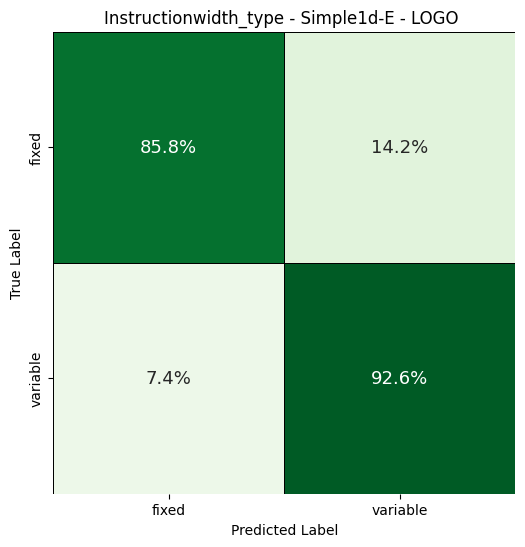

<Figure size 800x600 with 0 Axes>

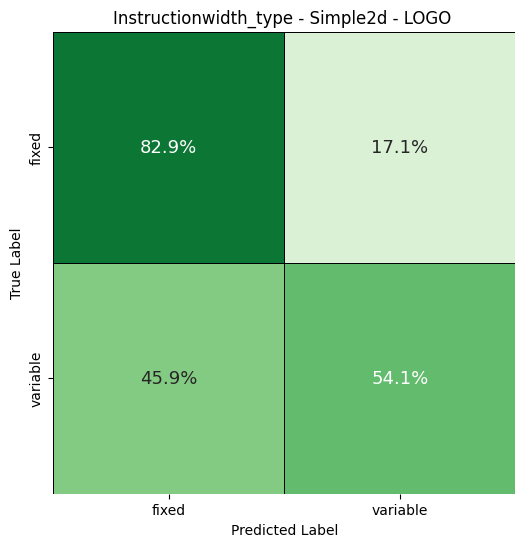

<Figure size 800x600 with 0 Axes>

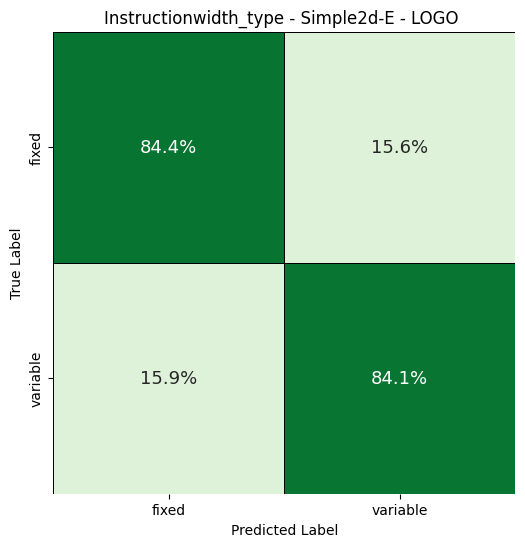

<Figure size 800x600 with 0 Axes>

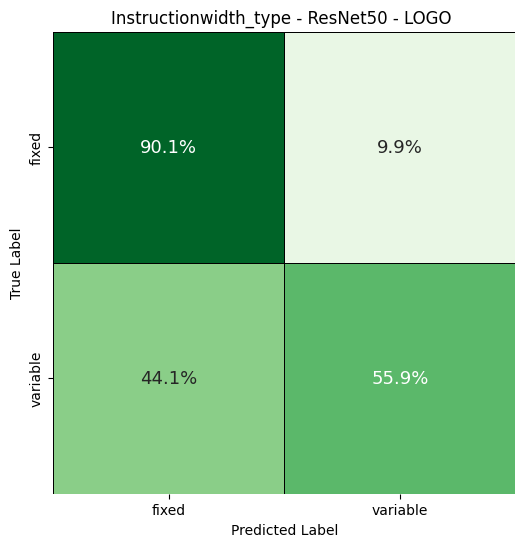

<Figure size 800x600 with 0 Axes>

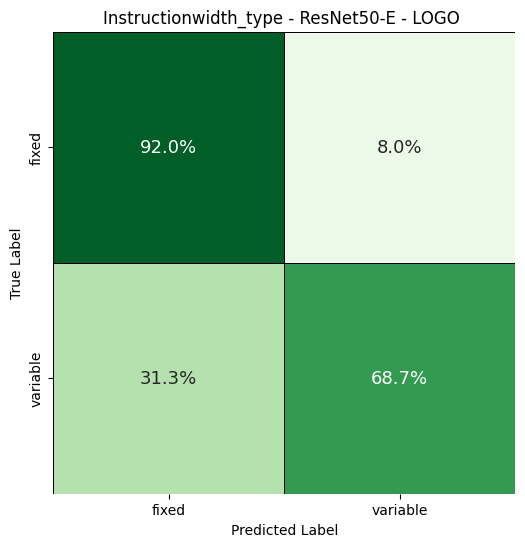

<Figure size 800x600 with 0 Axes>

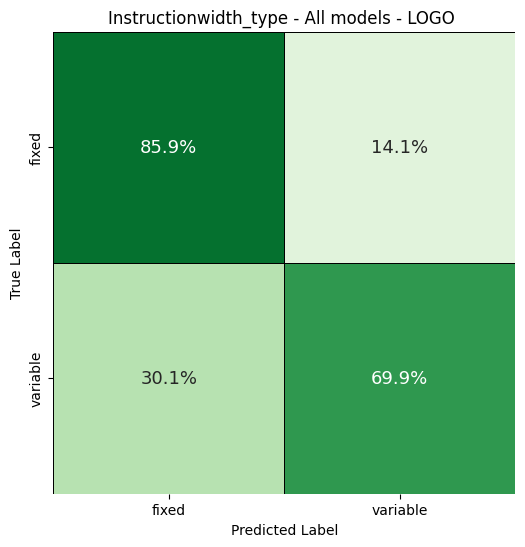

In [2]:
ISAdetect_df = pd.read_csv(
    os.path.join("../../dataset", "ISAdetect-features.csv"), delimiter=";"
)
ISAdetect_endianess_map = ISAdetect_df.set_index("architecture")["endianness"].to_dict()
ISAdetect_instructionwidth_type_map = ISAdetect_df.set_index("architecture")[
    "instructionwidth_type"
].to_dict()

for target_feature in target_features:
    if target_feature == "endianness":
        label_map = ISAdetect_endianess_map
    elif target_feature == "instructionwidth_type":
        label_map = ISAdetect_instructionwidth_type_map
    else:
        raise ValueError(f"Unknown target feature: {target_feature}")

    for cross_validation_suite in cross_validation_suites:
        csv_files = glob.glob(os.path.join(directory, cross_validation_suite))
        df_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

        suite_conf_matrices = []
        for model_name in model_names:
            model_label = model_name.replace("Embedding", "-E")
            df = df_all[
                (df_all["model.name"] == model_name)
                & (df_all["target_feature"] == target_feature)
            ].reset_index(drop=True)

            # Filter out rows with Name "overall_metrics"
            df_filtered = df[df["Name"] != "overall_metrics"]

            # Calculate confusion matrix here

            # Example usage with your existing code

            if df_filtered.empty:
                continue

            # Calculate confusion matrix values for each run (seed)
            confusion_matrices = []

            # Group by seed to calculate confusion matrix for each run
            for seed, seed_group in df_filtered.groupby("validator.seed"):
                # Initialize confusion matrix for this seed
                cm_seed = np.zeros((2, 2))  # 2x2 for binary classification
                for _, row in seed_group.iterrows():
                    architecture = row["group_left_out"]
                    true_label = label_map.get(architecture, "unknown")
                    if true_label not in index_0 and true_label not in index_1:
                        print(
                            f"Architecture '{architecture}' for model '{model_name}' and target feature '{target_feature}' not found in label map. Skipping."
                        )
                        continue

                    if true_label == "unknown":
                        print(
                            f"Unknown architecture '{architecture}' for model '{model_name}' and target feature '{target_feature}'. Skipping."
                        )
                        continue

                    # Calculate predicted counts
                    test_size = row["test_dataset_size"]
                    accuracy = row["test_accuracy_chunk"]
                    predicted_correct = int(accuracy * test_size)
                    predicted_incorrect = test_size - predicted_correct

                    # Map to matrix indices (0=big, 1=little)
                    true_idx = 0 if true_label in index_0 else 1

                    # For binary classification, we assume the model predicts the majority class
                    # when accuracy > 0.5, otherwise it predicts the minority class
                    cm_seed[true_idx, true_idx] += predicted_correct
                    cm_seed[true_idx, 1 - true_idx] += predicted_incorrect

                confusion_matrices.append(cm_seed)
                suite_conf_matrices.append(cm_seed)

            if confusion_matrices:
                # Average confusion matrix across all runs (seeds)
                avg_cm = np.mean(confusion_matrices, axis=0)

                # Plot confusion matrix
                class_names = (
                    ["big", "little"]
                    if target_feature == "endianness"
                    else ["fixed", "variable"]
                )
                plt.figure(figsize=(8, 6))
                plot_confusion_matrix(
                    cm=avg_cm,
                    class_names=class_names,
                    title=f"{target_feature.capitalize()} - {model_label} - {cross_validation_suite.replace('*.csv', '').replace('-', ' ')}",
                    normalize=True,
                    cmap=plt.cm.Greens,
                )

                os.makedirs("output/confusion-matrix/logo", exist_ok=True)
                plt.savefig(
                    f"output/confusion-matrix/logo/confusion-logo-{target_feature.replace("_","")}-{model_name.lower().replace("embedding", "-e")}.svg",
                    bbox_inches="tight",
                )

                # Print raw confusion matrix values
                print(f"\n{model_label} - {cross_validation_suite}:")
                print(
                    f"Raw confusion matrix (averaged across {len(confusion_matrices)} runs):"
                )
                print(f"{'':>10} {'big':>10} {'little':>10}")
                print(f"{'big':>10} {avg_cm[0,0]:>10.1f} {avg_cm[0,1]:>10.1f}")
                print(f"{'little':>10} {avg_cm[1,0]:>10.1f} {avg_cm[1,1]:>10.1f}")

        avg_cm = np.mean(suite_conf_matrices, axis=0)

        # Plot confusion matrix
        class_names = (
            ["big", "little"]
            if target_feature == "endianness"
            else ["fixed", "variable"]
        )
        plt.figure(figsize=(8, 6))
        plot_confusion_matrix(
            cm=avg_cm,
            class_names=class_names,
            title=f"{target_feature.capitalize()} - All models - {cross_validation_suite.replace('*.csv', '').replace('-', ' ')}",
            normalize=True,
            cmap=plt.cm.Greens,
        )

        os.makedirs("output/confusion-matrix/logo", exist_ok=True)
        plt.savefig(
            f"output/confusion-matrix/logo/confusion-logo-{target_feature.replace("_","")}-allmodels.svg",
            bbox_inches="tight",
        )

        # Print raw confusion matrix values
        print(f"\n{model_label} - {cross_validation_suite}:")
        print(f"Raw confusion matrix (averaged across {len(confusion_matrices)} runs):")
        print(f"{'':>10} {'big':>10} {'little':>10}")
        print(f"{'big':>10} {avg_cm[0,0]:>10.1f} {avg_cm[0,1]:>10.1f}")
        print(f"{'little':>10} {avg_cm[1,0]:>10.1f} {avg_cm[1,1]:>10.1f}")

### Train Test Eval


{'6502': 'little', '68HC08': 'big', '68HC11': 'big', '8051': 'na', 'Alpha': 'little', 'ARC32eb': 'big', 'ARC32el': 'little', 'ARcompact': 'little', 'ARM64': 'little', 'ARMeb': 'big', 'ARMel': 'little', 'ARMhf': 'little', 'AVR': 'na', 'AxisCris': 'little', 'Blackfin': 'little', 'Cell-SPU': 'bi', 'CLIPPER': 'little', 'CompactRISC': 'little', 'Cray': 'na', 'Epiphany': 'little', 'FR-V': 'big', 'FR30': 'big', 'FT32': 'little', 'H8-300': 'big', 'H8S': 'unk', 'HP-Focus': 'na', 'HP-PA': 'big', 'i860': 'bi', 'IA-64': 'little', 'IQ2000': 'big', 'M32C': 'little', 'M32R': 'big', 'M68k': 'big', 'M88k': 'big', 'MCore': 'little', 'Mico32': 'big', 'MicroBlaze': 'big', 'MIPS16': 'bi', 'MIPSeb': 'big', 'MIPSel': 'little', 'MMIX': 'big', 'MN10300': 'little', 'Moxie': 'big', 'MSP430': 'little', 'NDS32': 'little', 'NIOS-II': 'little', 'PDP-11': 'middle', 'PIC10': 'na', 'PIC16': 'na', 'PIC18': 'na', 'PIC24': 'little', 'PPCeb': 'big', 'PPCel': 'little', 'RISC-V': 'little', 'RL78': 'little', 'ROMP': 'big', 'R

/var/folders/5k/wrmk17fd2nz29w2bspmq6bm00000gn/T/ipykernel_80636/402002634.py:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))



ResNet50 - Combined-All.csv:
Raw confusion matrix (averaged across 20 runs):
                  big     little
       big       26.8        6.2
    little        8.2       14.8

ResNet50-E - Combined-All.csv:
Raw confusion matrix (averaged across 20 runs):
                  big     little
       big       29.4        3.6
    little        5.0       17.9

ResNet50-E - Combined-All.csv:
Raw confusion matrix (averaged across 20 runs):
                  big     little
       big       27.5        5.5
    little        7.1       15.9
train_test_suite CpuRec-All.csv

Simple1d - CpuRec-All.csv:
Raw confusion matrix (averaged across 20 runs):
                  big     little
       big       29.6        3.5
    little       12.4       10.6

Simple1d-E - CpuRec-All.csv:
Raw confusion matrix (averaged across 20 runs):
                  big     little
       big       26.5        6.5
    little        7.2       15.8

Simple2d - CpuRec-All.csv:
Raw confusion matrix (averaged across 20 runs):
     

<Figure size 800x600 with 0 Axes>

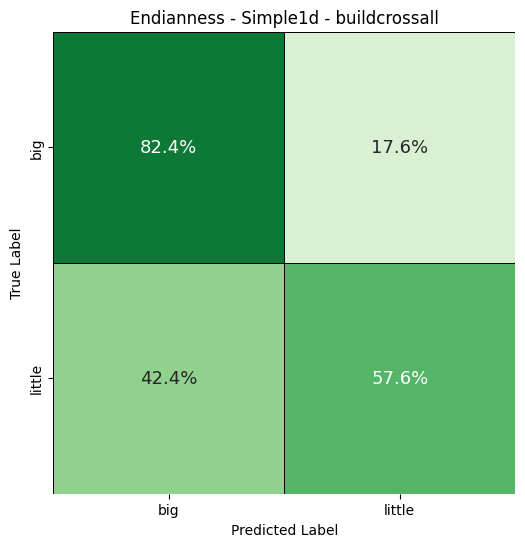

<Figure size 800x600 with 0 Axes>

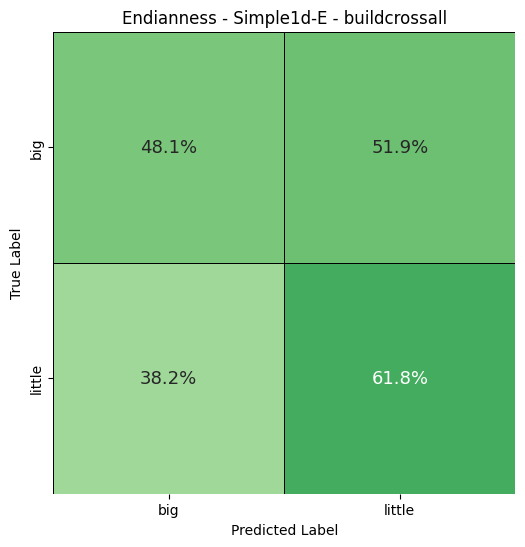

<Figure size 800x600 with 0 Axes>

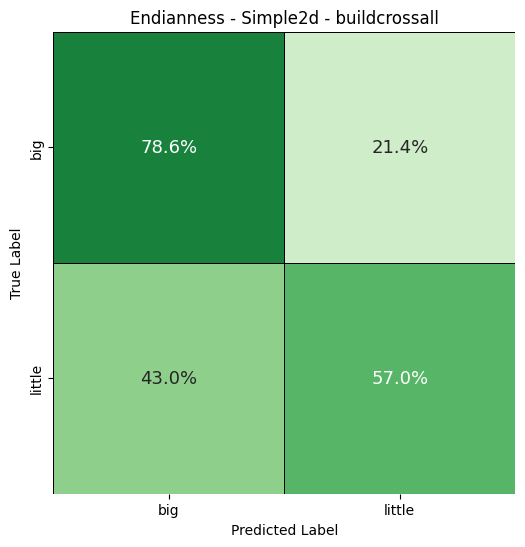

<Figure size 800x600 with 0 Axes>

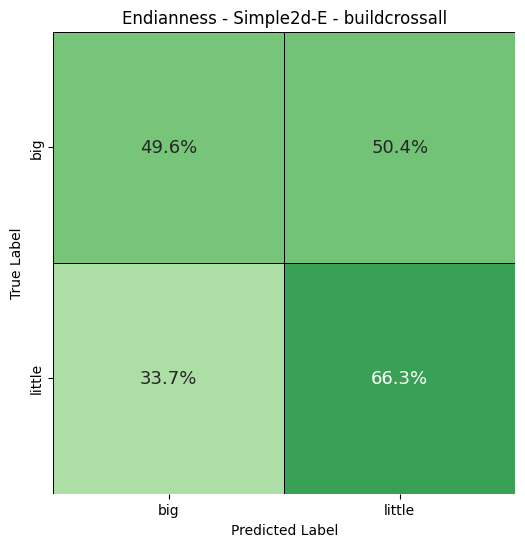

<Figure size 800x600 with 0 Axes>

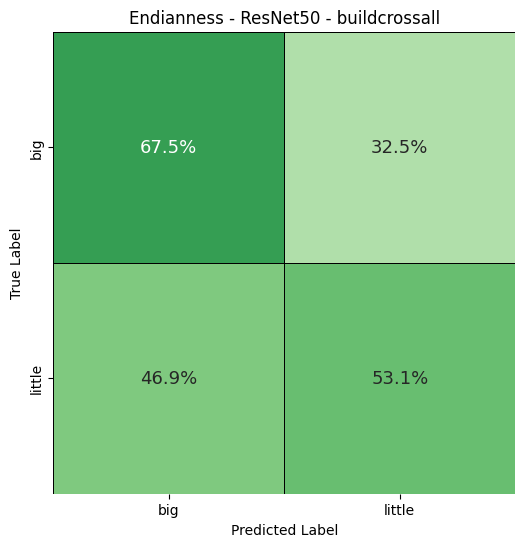

<Figure size 800x600 with 0 Axes>

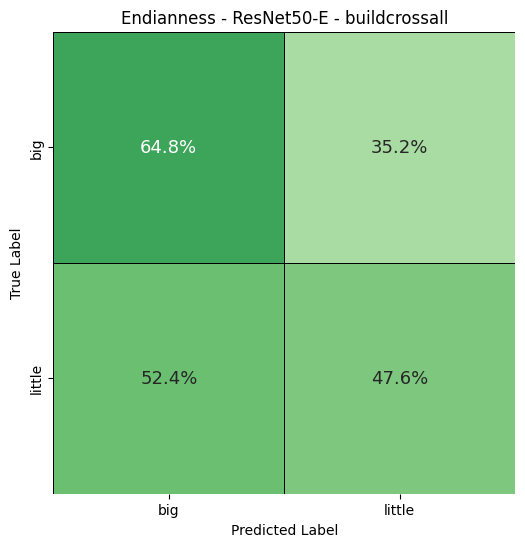

<Figure size 800x600 with 0 Axes>

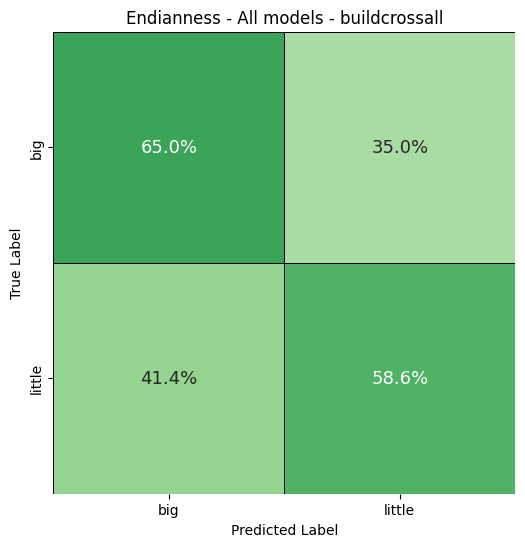

<Figure size 800x600 with 0 Axes>

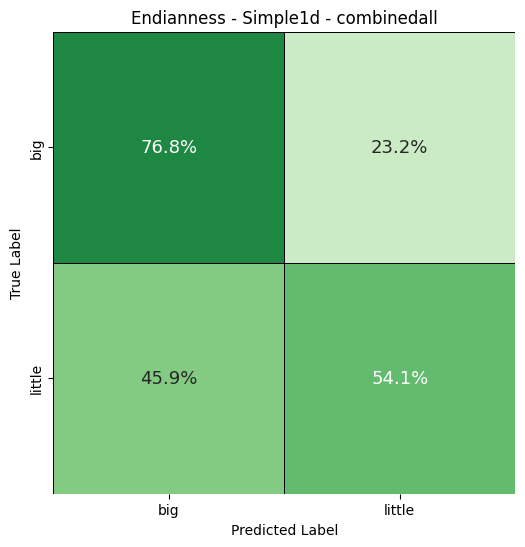

<Figure size 800x600 with 0 Axes>

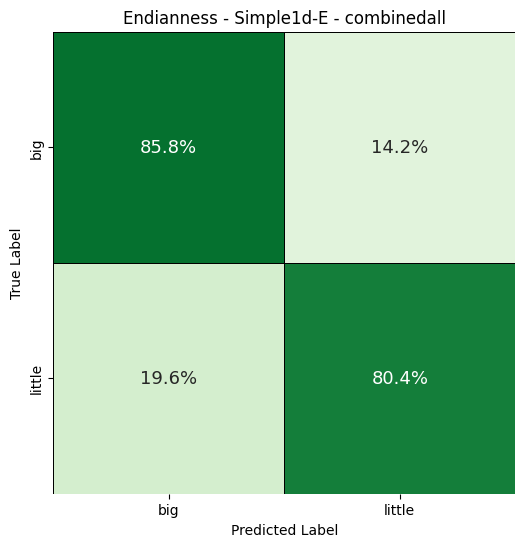

<Figure size 800x600 with 0 Axes>

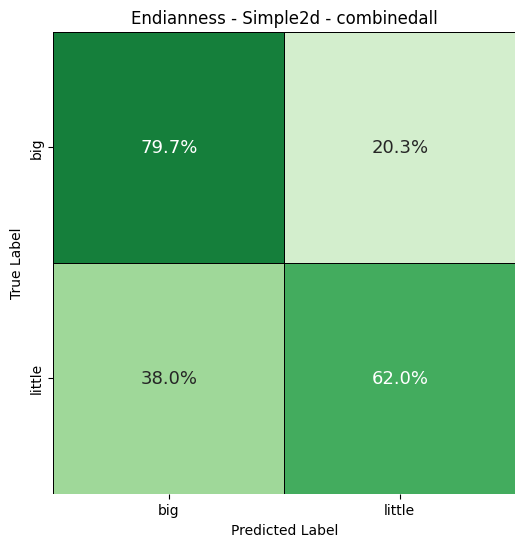

<Figure size 800x600 with 0 Axes>

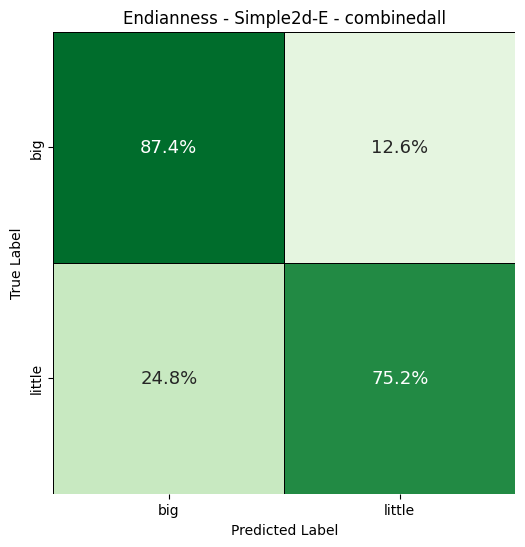

<Figure size 800x600 with 0 Axes>

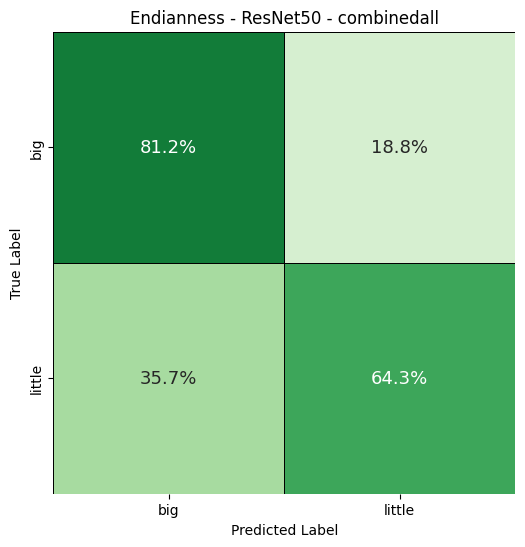

<Figure size 800x600 with 0 Axes>

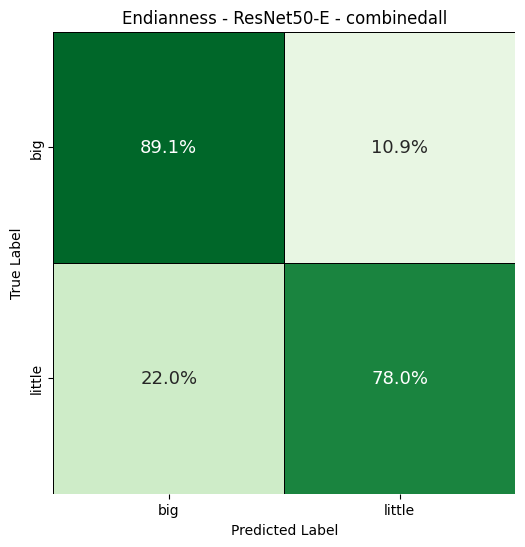

<Figure size 800x600 with 0 Axes>

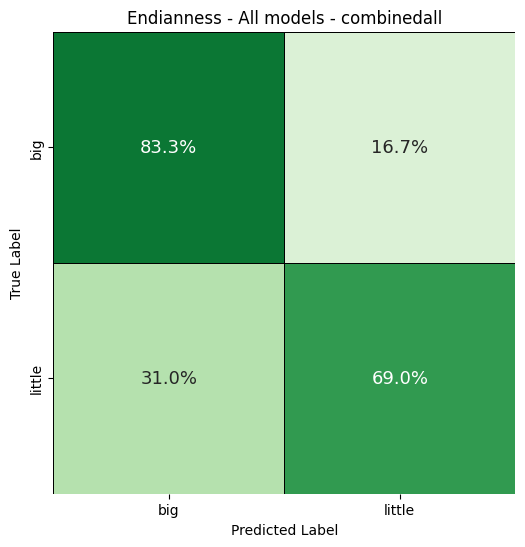

<Figure size 800x600 with 0 Axes>

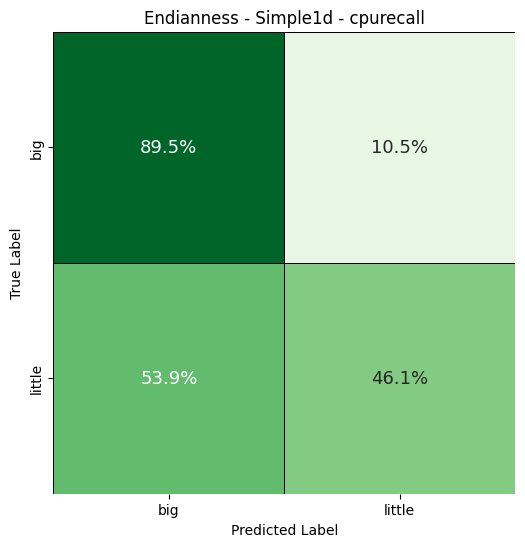

<Figure size 800x600 with 0 Axes>

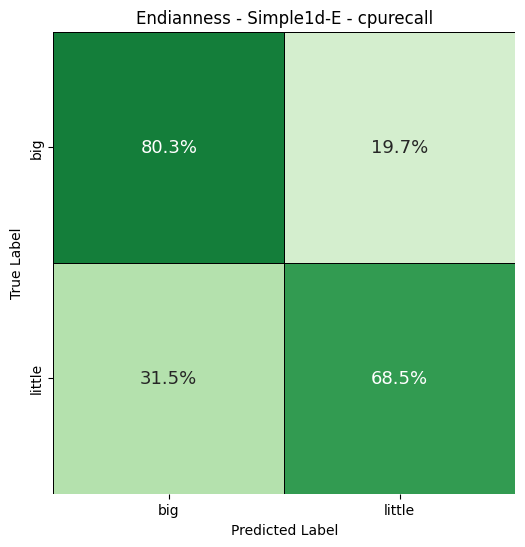

<Figure size 800x600 with 0 Axes>

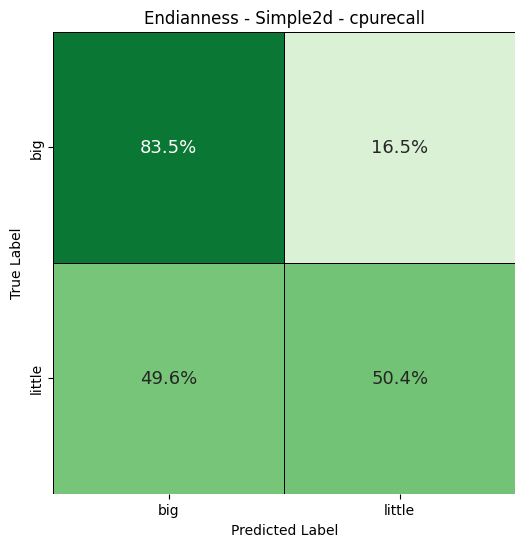

<Figure size 800x600 with 0 Axes>

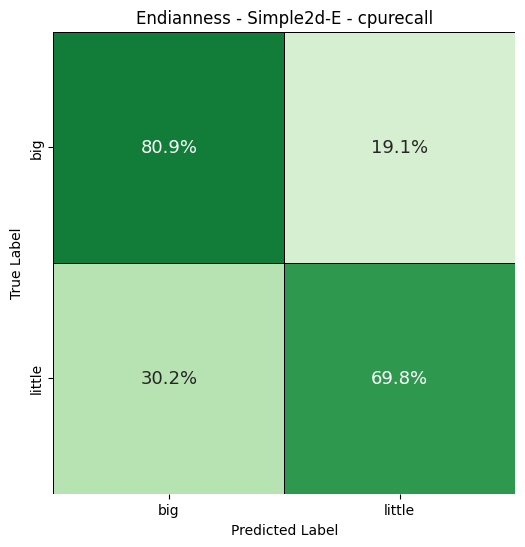

<Figure size 800x600 with 0 Axes>

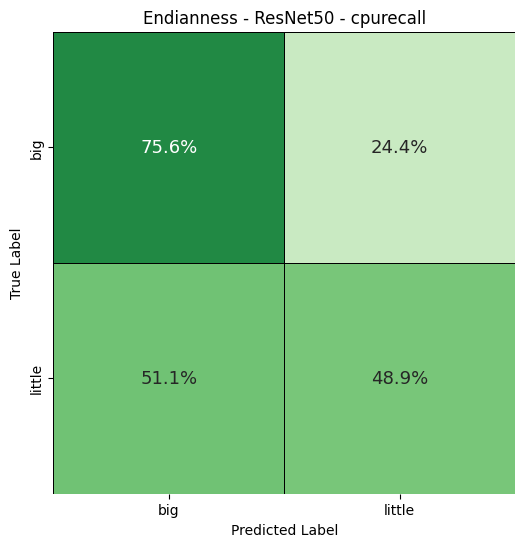

<Figure size 800x600 with 0 Axes>

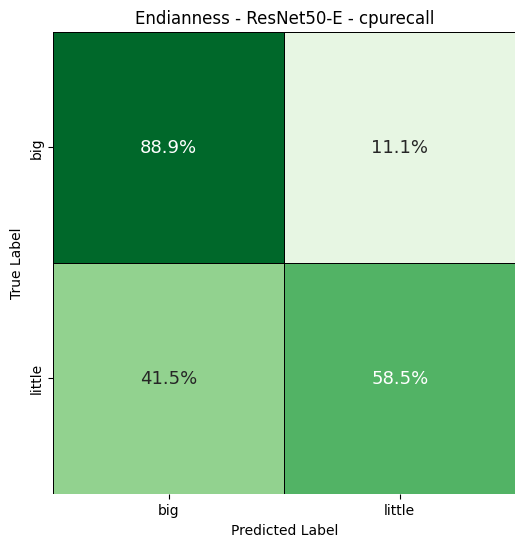

<Figure size 800x600 with 0 Axes>

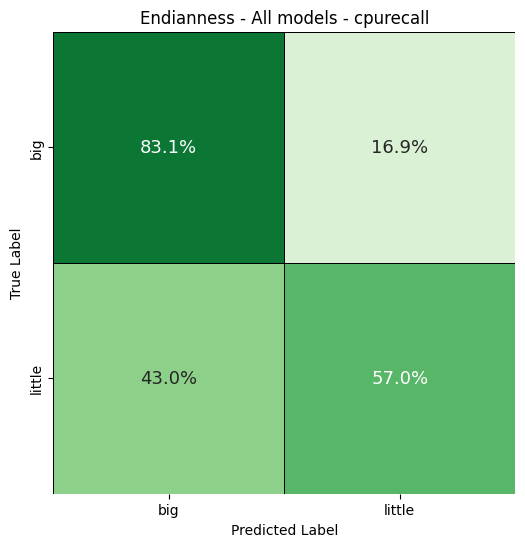

<Figure size 800x600 with 0 Axes>

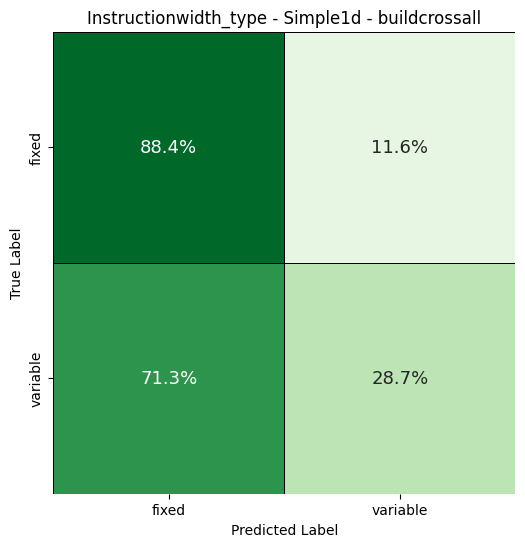

<Figure size 800x600 with 0 Axes>

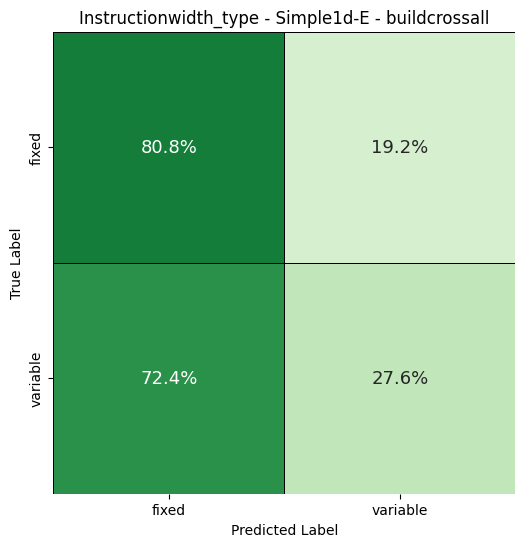

<Figure size 800x600 with 0 Axes>

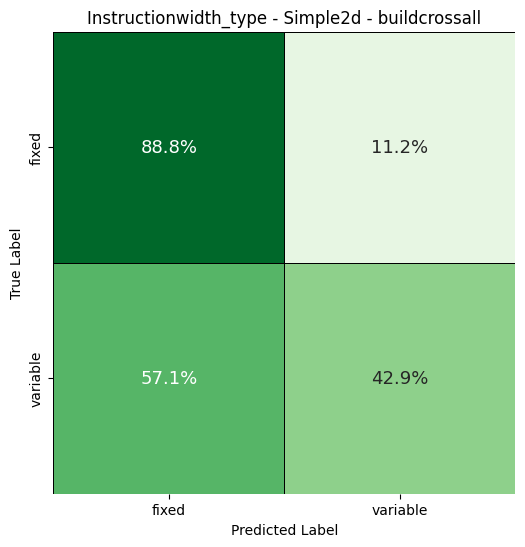

<Figure size 800x600 with 0 Axes>

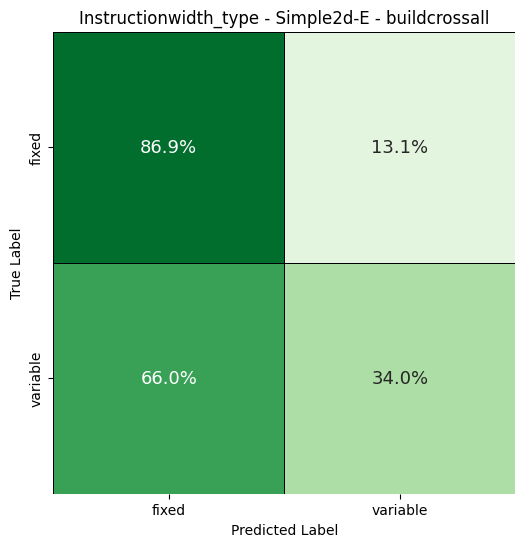

<Figure size 800x600 with 0 Axes>

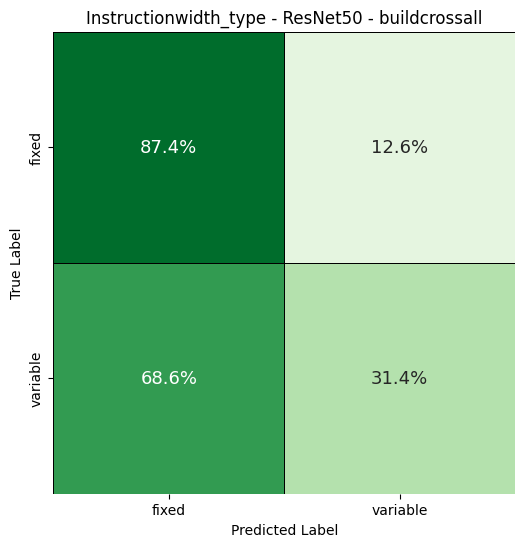

<Figure size 800x600 with 0 Axes>

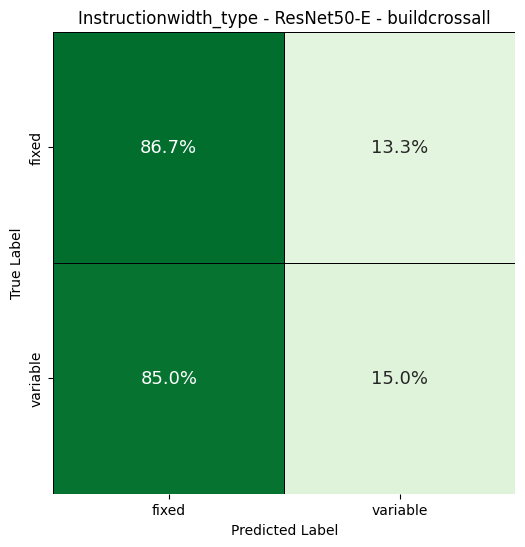

<Figure size 800x600 with 0 Axes>

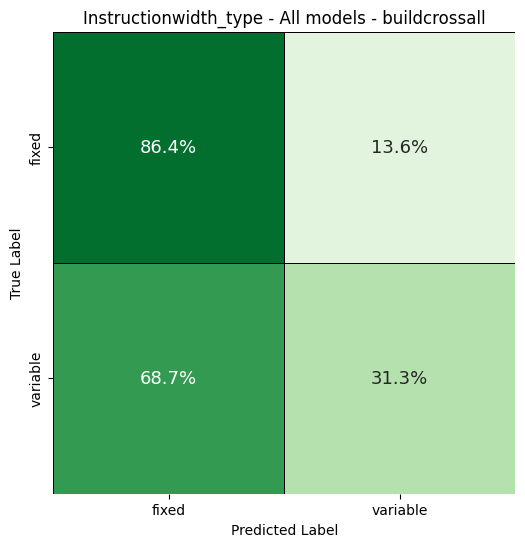

<Figure size 800x600 with 0 Axes>

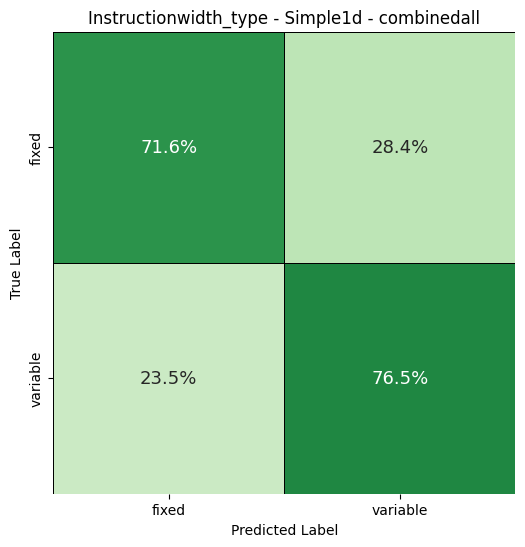

<Figure size 800x600 with 0 Axes>

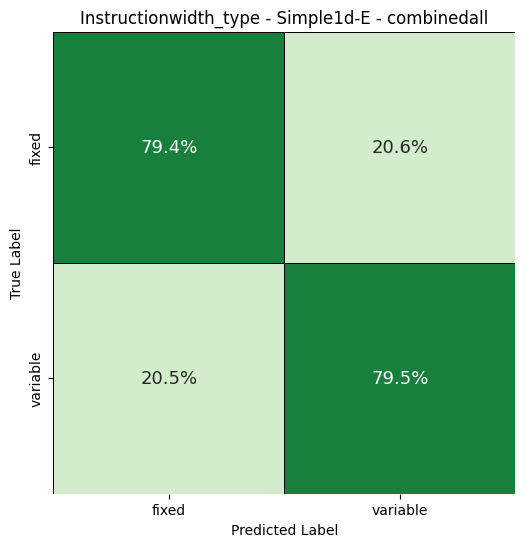

<Figure size 800x600 with 0 Axes>

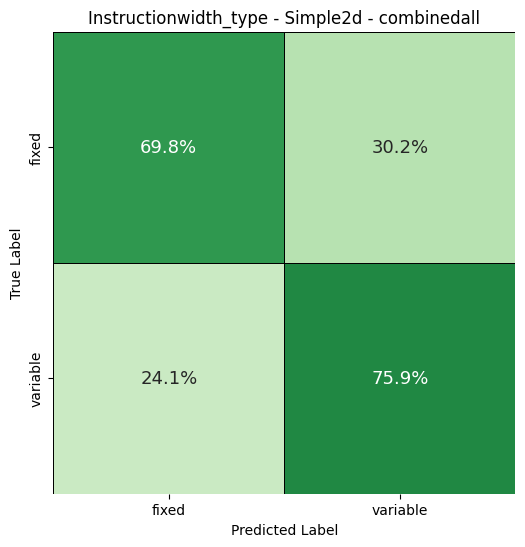

<Figure size 800x600 with 0 Axes>

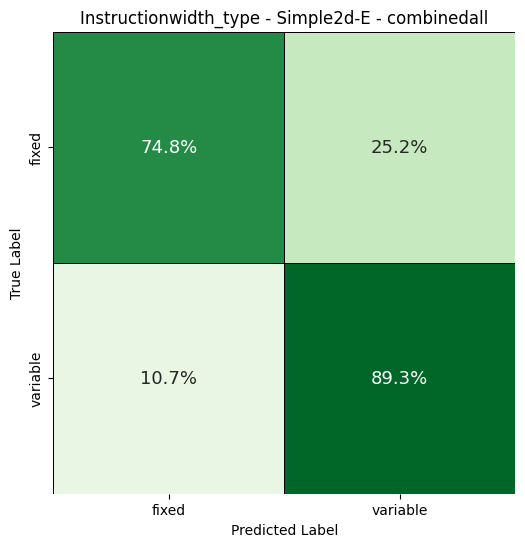

<Figure size 800x600 with 0 Axes>

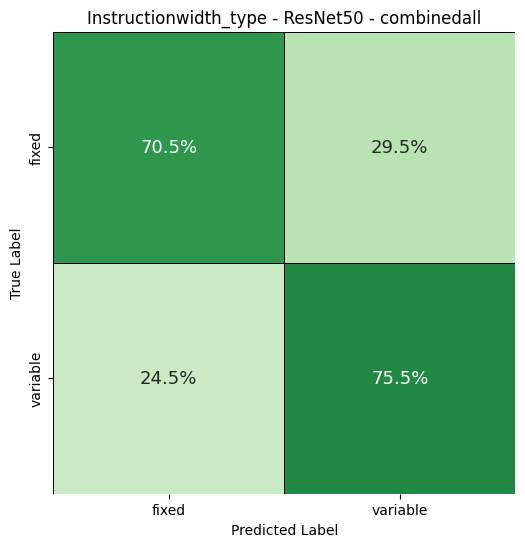

<Figure size 800x600 with 0 Axes>

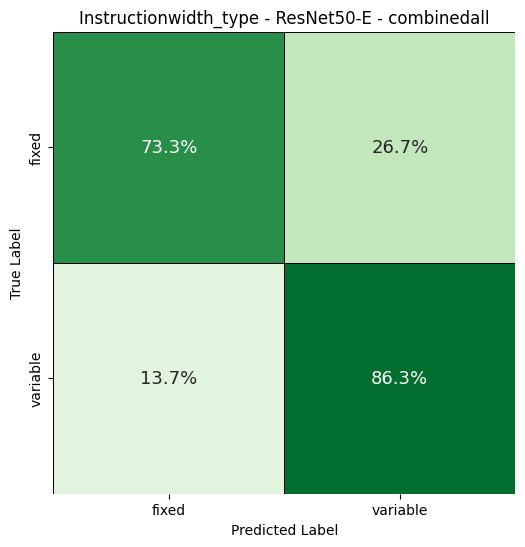

<Figure size 800x600 with 0 Axes>

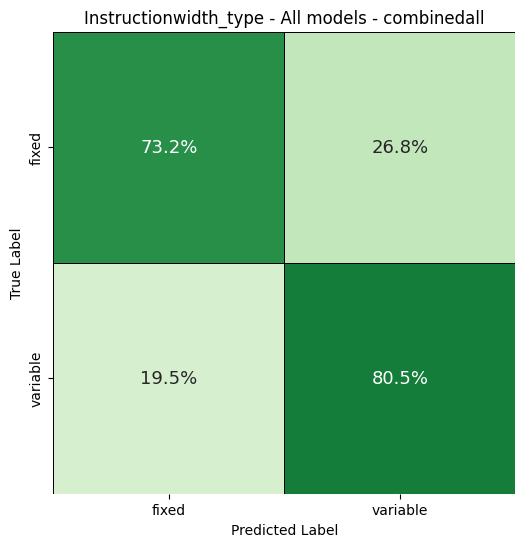

<Figure size 800x600 with 0 Axes>

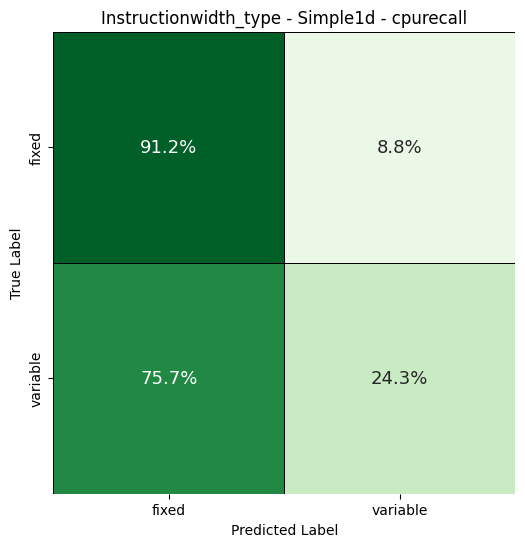

<Figure size 800x600 with 0 Axes>

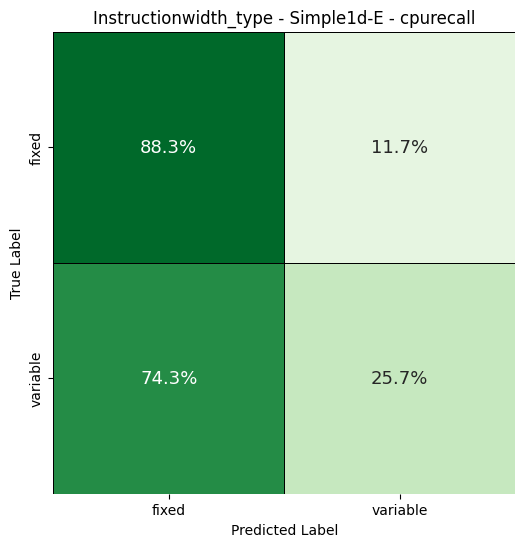

<Figure size 800x600 with 0 Axes>

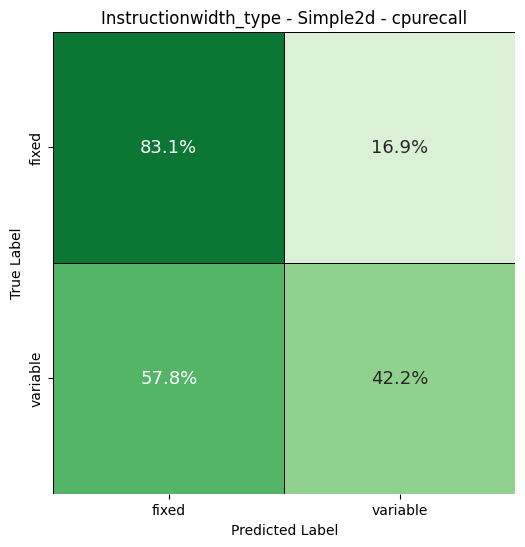

<Figure size 800x600 with 0 Axes>

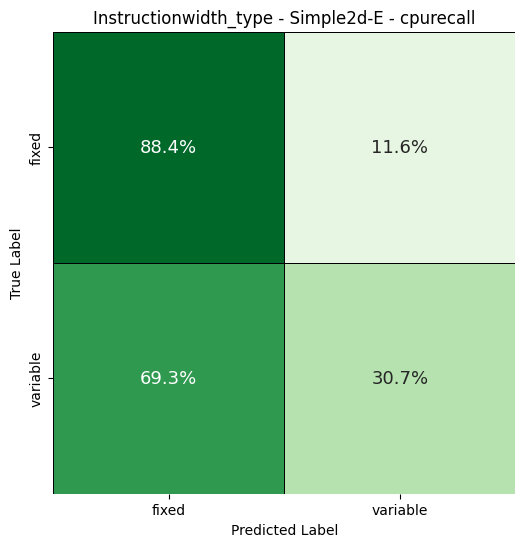

<Figure size 800x600 with 0 Axes>

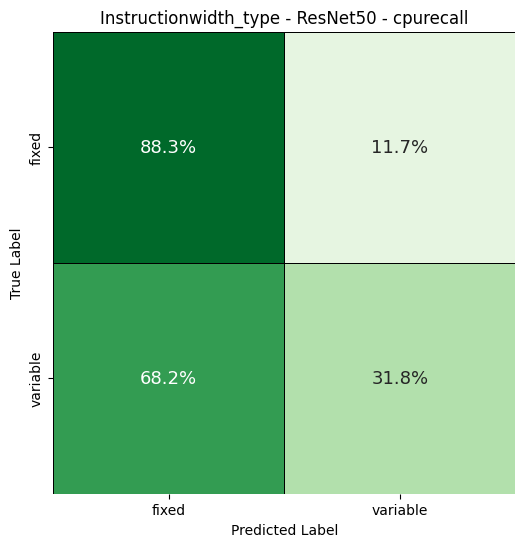

<Figure size 800x600 with 0 Axes>

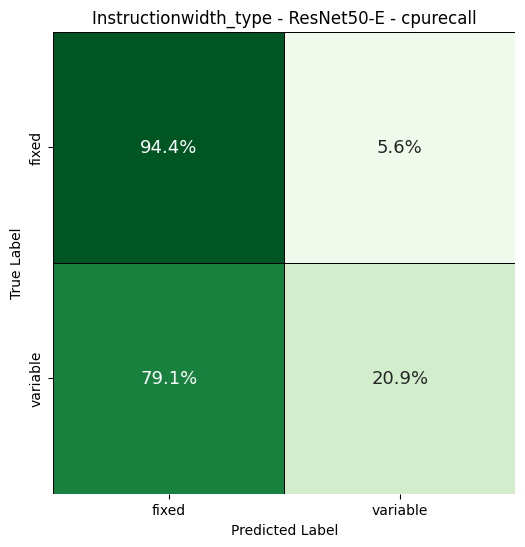

<Figure size 800x600 with 0 Axes>

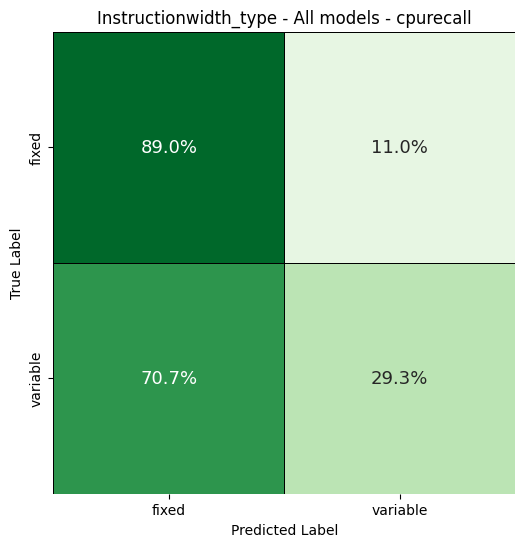

In [3]:
cpu_rec_df = pd.read_csv(
    os.path.join("../../dataset", "cpu_rec-features.csv"), delimiter=";"
)
cpu_rec_endianess_map = cpu_rec_df.set_index("architecture")["endianness"].to_dict()
cpu_rec_instructionwidth_type_map = cpu_rec_df.set_index("architecture")[
    "instructionwidth_type"
].to_dict()

buildcross_df = pd.read_csv(
    os.path.join("../../dataset/buildcross", "labels.csv"), delimiter=";"
)
buildcross_endianess_map = buildcross_df.set_index("architecture")[
    "endianness"
].to_dict()
buildcross_instructionwidth_type_map = buildcross_df.set_index("architecture")[
    "instructionwidth_type"
].to_dict()

print(cpu_rec_endianess_map)
print(buildcross_endianess_map)

for target_feature in target_features:
    for train_test_suite in train_test_suites:
        print("train_test_suite", train_test_suite)
        csv_files = glob.glob(os.path.join(directory, train_test_suite))
        df_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

        if target_feature == "endianness":
            if train_test_suite == "BuildCross-All.csv":
                label_map = buildcross_endianess_map
            else:
                label_map = cpu_rec_endianess_map
        elif target_feature == "instructionwidth_type":
            if train_test_suite == "BuildCross-All.csv":
                label_map = buildcross_instructionwidth_type_map
            else:
                label_map = cpu_rec_instructionwidth_type_map
        else:
            raise ValueError(f"Unknown target feature: {target_feature}")

        suite_conf_matrices = []
        for model_name in model_names:
            model_label = model_name.replace("Embedding", "-E")
            df = df_all[
                (df_all["validator.name"] == "train_test_separate_datasets")
                & (df_all["model.name"] == model_name)
                & (df_all["target_feature"] == target_feature)
            ].reset_index(drop=True)

            # Get all columns that start with "instance_count_" to identify architectures
            architectures = [
                col.replace("instance_count_", "")
                for col in df.columns
                if col.startswith("instance_count_")
            ]

            # Calculate confusion matrix values for each run (seed)
            confusion_matrices = []

            # Group by seed to calculate confusion matrix for each run
            for seed, seed_group in df.groupby("validator.seed"):
                # Initialize confusion matrix for this seed
                cm_seed = np.zeros((2, 2))  # 2x2 for binary classification
                correct_count = 0
                for _, row in seed_group.iterrows():
                    predicted_correct = 0
                    predicted_incorrect = 0
                    for arch in architectures:
                        true_label = label_map.get(arch, "unknown")
                        if true_label not in index_0 and true_label not in index_1:
                            # print(
                            #    f"Architecture '{arch}' and target feature '{target_feature}' not found in label map. Skipping."
                            # )
                            continue
                        elif true_label == "unknown":
                            # print(
                            #    f"Unknown architecture '{arch}' for model '{model_name}' and target feature '{target_feature}'. Skipping."
                            # )
                            continue

                        # Calculate predicted counts
                        arch_size = row["instance_count_" + arch]
                        arch_accuracy = row["test_accuracy_" + arch]
                        predicted_correct = int(arch_accuracy * arch_size)
                        predicted_incorrect = arch_size - predicted_correct

                        # Map to matrix indices (0=big, 1=little)
                        true_idx = 0 if true_label in index_0 else 1
                        # print(predicted_correct, predicted_incorrect, true_idx)

                        # For binary classification, we assume the model predicts the majority class
                        # when accuracy > 0.5, otherwise it predicts the minority class
                        cm_seed[true_idx, true_idx] += predicted_correct
                        cm_seed[true_idx, 1 - true_idx] += predicted_incorrect
                        correct_count += predicted_correct
                    confusion_matrices.append(cm_seed)
                    suite_conf_matrices.append(cm_seed)

            if confusion_matrices:
                # Average confusion matrix across all runs (seeds)
                avg_cm = np.mean(confusion_matrices, axis=0)

                class_names = (
                    ["big", "little"]
                    if target_feature == "endianness"
                    else ["fixed", "variable"]
                )
                validation_suite_name = (
                    train_test_suite.replace(".csv", "").replace("-", "").lower()
                )
                plt.figure(figsize=(8, 6))
                plot_confusion_matrix(
                    cm=avg_cm,
                    class_names=class_names,
                    title=f"{target_feature.capitalize()} - {model_label} - {validation_suite_name}",
                    normalize=True,
                    cmap=plt.cm.Greens,
                )

                save_dir = f"output/confusion-matrix/{validation_suite_name}"
                os.makedirs(save_dir, exist_ok=True)
                plt.savefig(
                    f"{save_dir}/confusion-{validation_suite_name}-{target_feature.replace("_","")}-{model_name.lower().replace("embedding", "-e")}.svg",
                    bbox_inches="tight",
                )

                # Print raw confusion matrix values
                print(f"\n{model_label} - {train_test_suite}:")
                print(
                    f"Raw confusion matrix (averaged across {len(confusion_matrices)} runs):"
                )
                print(f"{'':>10} {'big':>10} {'little':>10}")
                print(f"{'big':>10} {avg_cm[0,0]:>10.1f} {avg_cm[0,1]:>10.1f}")
                print(f"{'little':>10} {avg_cm[1,0]:>10.1f} {avg_cm[1,1]:>10.1f}")

        avg_cm = np.mean(suite_conf_matrices, axis=0)
        class_names = (
            ["big", "little"]
            if target_feature == "endianness"
            else ["fixed", "variable"]
        )
        validation_suite_name = (
            train_test_suite.replace(".csv", "").replace("-", "").lower()
        )
        plt.figure(figsize=(8, 6))
        plot_confusion_matrix(
            cm=avg_cm,
            class_names=class_names,
            title=f"{target_feature.capitalize()} - All models - {validation_suite_name}",
            normalize=True,
            cmap=plt.cm.Greens,
        )

        save_dir = f"output/confusion-matrix/{validation_suite_name}"
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(
            f"{save_dir}/confusion-{validation_suite_name}-{target_feature.replace("_","")}-all-models.svg",
            bbox_inches="tight",
        )

        # Print raw confusion matrix values
        print(f"\n{model_label} - {train_test_suite}:")
        print(f"Raw confusion matrix (averaged across {len(confusion_matrices)} runs):")
        print(f"{'':>10} {'big':>10} {'little':>10}")
        print(f"{'big':>10} {avg_cm[0,0]:>10.1f} {avg_cm[0,1]:>10.1f}")
        print(f"{'little':>10} {avg_cm[1,0]:>10.1f} {avg_cm[1,1]:>10.1f}")